### Causal relation classification: using Pre-trained BERT model

### Causal relation classification: Trying to find is there a causal relation in the paragraph<br>

A fun example:
<img src="https://i1.wp.com/boingboing.net/wp-content/uploads/2020/11/Screen-Shot-2020-11-15-at-6.15.14-AM.png?fit=1208%2C786&ssl=1" style="width:400px;height:300px">


In this task, we will implement a bert model to classify whether a paragraph contains a causal relation. Instead of using the last hidden state([CLS] token from the last transformer layer) as a paragraph embedding to train a linear classifier on in notebook *1.2-causal-relation-presence-bert-embeddings*, now we will start with a pre-trained BERT model and retrain the full model on our data. To illustrate the difference between this approach and *1.2-causal-relation-presence-bert-embeddings*, the differences are:
* the classifier(here we use Feed-forward Neural network with softmax, vs Logistic regression with Sigmoid) 
* we re-train the full BERT model on our data.

### 1. Data preparation

In [1]:
cd ..

In [2]:
from collections import OrderedDict 
import itertools
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import os
import pprint
import pandas as pd
import random
from sklearn.utils import shuffle,resample
from sklearn.metrics import classification_report,confusion_matrix,f1_score
from sklearn.model_selection import train_test_split,KFold
from src.data.make_dataset import read_data_file,make_dataset
import time
import datetime
import seaborn as sns
import torch
import tqdm
import warnings
from transformers import BertTokenizer,RobertaTokenizer,BertForSequenceClassification,get_linear_schedule_with_warmup,AdamW, BertConfig, RobertaForSequenceClassification
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
import wandb


warnings.filterwarnings('ignore')

In [3]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    

#set random seed to keep consistency between different experiments
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
if str(device) == 'cuda':
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
else:
    torch.manual_seed(seed_val)

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2070 SUPER


In [4]:
assert os.path.isdir("csv"), 'The directory "csv" does not exist!'
assert os.path.isdir("txt"), 'The directory "txt" does not exist!'
map_contents = read_data_file("csv/Map_Contents-20200726.csv")
speech_contents = read_data_file("csv/Speech_Contents-20210520.txt")
speeches = read_data_file("csv/Speeches-20210520.txt")

In [5]:
X, y = make_dataset(speeches, speech_contents, map_contents)

skipping file in language fr: 2009-12-01 Sarkozy Elysee (Economy) ann fr.txt
skipping file in language fr: 2009-12-14 Sarkozy Elysee (Economy) ann fr.txt
skipping file in language fr: 2010-04-20 Barroso European Commission ann fr.txt
skipping file in language fr: 2011-01-13 Sarkozy gb ann.txt
skipping file in language nl: 2011-04-06 Rutte FD evenement ann NL.txt
skipping file in language nl: 2011-09-27 Rutte Rijksoverheid ann.txt
skipping file in language nl: 2011-10-28 Knot dnb_01 ANN NL.txt
skipping file in language de: 2012-01-06 Rutte CSU klausurtagung ann G.txt
skipping file in language unk: 2012-07-26 Barroso European Commission.txt
skipping file in language fr: 2012-08-30 Hollande SFM2020 ann fr.txt
skipping file in language fr: 2013-02-19 Hollande SFM2020 ann fr.txt
skipping file in language fr: 2013-04-17 Hollande SFM2020 ann fr.txt
skipping file in language de: 2013-11-21 Merkel Bundesregerung ann g.txt
skipping file in language de: 2014-02-27 Merkel Bundesregerung ann g.txt


### 2. Balance the data

1.First of all, there still are some *Missing value* paragraphs in our data, therefore we need to remove them. <br><br>
2.In addition, our data is highly imbalanced, that's means we have twice as many paragraphs with causal relations compared to paragraphs without causal relations. This issue would make our classifier guess a paragraph contains causal relation with a high probability because it would be less likely to make a mistake, but this is not what we want. Therefore we need to balance our data.<br>

<h1><center>Undersampling VS  Oversampling</center></h1>

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

There are two common methods of balancing data: Undersampling and Oversampling, the former refers to the random sampling from the class which contains more data in order to make the dataset balanced. The latter is to copy data points from the class with less data, then make the dataset balanced.<br><br>
Both methods have their advantages and disadvantages, where Undersampling will make us discard some existing data, which will cost our model some training opportunities given our small data size. Nonetheless, oversampling "manually" improves the accuracy of the model because some data appear twice in the dataset, which means that the data points that appear in the test set are likely to appear in the training set as well.

In [6]:
def over_sampling(X,y):
    """
    remove Missing value first, then output two balanced dataset (Undersampling and Oversampling)
    Input: X,y before pre-processing
    Output: dataframes after removing missing value, Undersampling and Oversampling
    """
    df = pd.DataFrame({'X':pd.Series(X),'y':pd.Series(y)})
    df_true = df[df['y'] == True]
    df_false = df[df['y'] == False] 
    
    #Upsampling, for the class with less data, copy some data 
    df_false_upsampled = resample(df_false,random_state=seed_val,n_samples=len(df_true),replace=True)
    df_upsampled = pd.concat([df_false_upsampled,df_true])
    df_upsampled = shuffle(df_upsampled)
    
    print('\nWe totally have {} training data after oversampling.'.format(len(df_upsampled)))
    return df_upsampled

def transform_df(df_upsampled):
    #transform label to int
    df_upsampled.loc[df_upsampled['y'] == 'True', 'y'] = 1
    df_upsampled.loc[df_upsampled['y'] == 'False', 'y'] = 0
    df_upsampled.y = df_upsampled.y.astype(int)
    
    #get sentences and label, will use them to do the tokenization
    #sentences = df_upsampled.X.values
    #labels = df_upsampled.y.values
    return df_upsampled

### Model processing flow

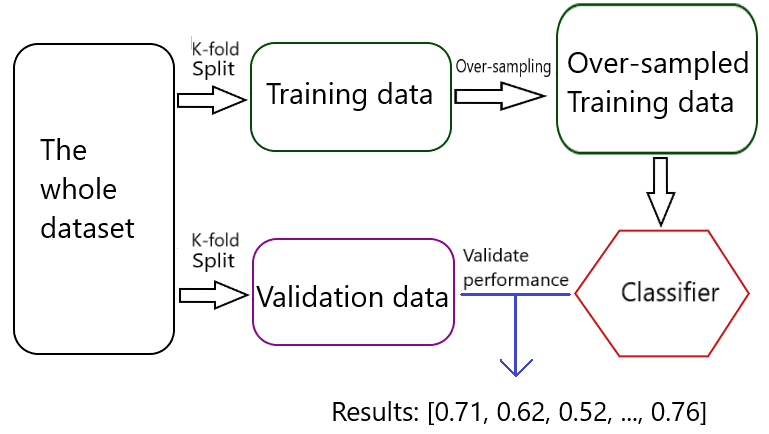


As shown in the Model processing flow above, we will only use over-sampling in a appropriate way: After using kfold spliting training set and test set, only the training set data will be over-sampled, which ensure that we won't have duplicate test data.

### 3. Re-train a end-to-end Pre-trained BERT Classification model


<img src="http://www.mccormickml.com/assets/BERT/padding_and_mask.png" style="width:600px;height:500px">

Our first step is to tokenize the paragraphs -- break them up into word and subwords in the format BERT is comfortable with. This process contains adding [CLS] and [SEP] tokens as well as substituting tokens with their IDs (tokens2IDs). 

After tokenization, tokenized is a list of paragraphs -- each paragraph is represented as a list of tokens. And we want BERT to process our examples all at once (as one batch). It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths). 

However, if we directly send padded to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. Finally, we will re-train the bert model then validate on eval_set, the corresponding visualization will be implemented as well.


#### Preparation functions

In [7]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

#### Transformer functions

In [8]:
def tokenize_process(df,tokenizer,max_length):
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []
    
    sentences = df.X.values
    labels = df.y.values
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_length,   # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
    
    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    # Print sentence 0, now as a list of IDs.
    #print('Check the original paragraph and converted paragrapg: ')
    #print('Original: ', sentences[1])
    #print('Token IDs:', input_ids[1])
    
    dataset = TensorDataset(input_ids, attention_masks, labels)
    return dataset

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def convert_logits_tolabel(logits):
        pred = []
        for i in logits:
            if i[0]> i[1]:
                pred.append(0)
            else:
                pred.append(1)
        return pred

In [9]:
def Training_and_evaluating(model,train_dataloader,validation_dataloader,optimizer,epochs,scheduler,total_steps):
    print('\nTraining and evaluating the model.')
    
    #store a number of quantities such as training and validation loss,validation accuracy, and timings.
    training_stats = []
    total_t0 = time.time()
    
    #store prediction and true labels
    train_logits = []
    train_label = []
    best_loss = 1.0
    # For each epoch...
    for epoch_i in range(0, epochs):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.
    
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
    
        # Measure how long the training epoch takes.
        t0 = time.time()
        # Reset the total loss for this epoch.
        total_train_loss = 0
        model.train()
        
        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
    
            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
    
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].long().to(device)
    
            model.zero_grad()        
            loss, logits = model(b_input_ids, 
                                 token_type_ids=None, 
                                 attention_mask=b_input_mask, 
                                 labels=b_labels)
            
            logits_ = logits.detach().cpu().numpy()
            label_ids_ = b_labels.to('cpu').numpy()
            
            #store prediction for the last epoch
            if epoch_i == epochs-1:
                train_logits.extend(logits_)
                train_label.extend(label_ids_)
            total_train_loss += loss.item()
    
            # Perform a backward pass to calculate the gradients.
            loss.backward()
            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
            # Update parameters and take a step using the computed gradient.Update the learning rate.
            optimizer.step()
        
        #Update scheduler(lr decay) every epoch
        lr_stat_opt = optimizer.param_groups[0]["lr"] #or lr_stat_scheduler = scheduler.get_last_lr()[0]
        print('current lr is:',lr_stat_opt)
        if scheduler:
            scheduler.step()
        
        #wandb.log({"lr": lr_stat_opt})
    
        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)
    
        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))
            
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.
    
        print("")
        print("Running Validation...")
        eval_pred = []
        eval_label = []
        t0 = time.time()
        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()
        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        # Evaluate data for one epoch
        for batch in validation_dataloader:
            
            # Unpack this training batch from our dataloader. 
            # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
            # `batch` contains three pytorch tensors: [0]: input ids; [1]: attention masks; [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].long().to(device)
            
            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        
                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                (loss, logits) = model(b_input_ids, 
                                       token_type_ids=None, 
                                       attention_mask=b_input_mask,
                                       labels=b_labels)
                
            # Accumulate the validation loss.
            total_eval_loss += loss.item()
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            #total_eval_accuracy += flat_accuracy(logits, label_ids)
            eval_pred.extend(logits)
            eval_label.extend(label_ids)
        

        eval_pred = convert_logits_tolabel(eval_pred)
        f1_val = f1_score(eval_label,eval_pred,average='macro')
        
        
        # Report the final accuracy for this validation run.
        #avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Macro F1 score: {0:.2f}".format(f1_val))
        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))
        
        
        #early-stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            # At this point also save a snapshot of the current model
            torch.save(model, 'my_model_best_loss.pth')
            
        
        #wandb.log({"Training Loss": avg_train_loss, "Valid. Loss":avg_val_loss,"Valid. Macro F1":f1_val, "epoch": epoch_i + 1 })
        
        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Macro F1.': f1_val,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
    
    print("")
    print("Training complete!")
    
    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    
    pd.set_option('precision', 2)
    # Create a DataFrame from our training statistics.
    df_stats = pd.DataFrame(data=training_stats)
    # Use the 'epoch' as the row index.
    df_stats = df_stats.set_index('epoch')
    
    # Plot the learning curve.
    plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
    plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
    
    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    epoch_list = [i+1 for i in range(epochs)]
    plt.xticks(epoch_list)
    
    plt.show()
    
    
    train_pred = convert_logits_tolabel(train_logits)
    
    return train_pred,eval_pred,train_label,eval_label

def get_prediction(df_test,model,batch_size,max_length,model_name):
    if model_name=='bert':
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    elif model_name=='roberta':
        tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    else:
        raise SystemExit('Invalid model_name, model could only be one of [bert, roberta] ')

    test_dataset = tokenize_process(df_test,tokenizer,max_length)
    test_dataloader = DataLoader(test_dataset,sampler = SequentialSampler(test_dataset),batch_size = batch_size)
    
    test_logits = []
    test_label = []
    model.eval()
    
    for batch in test_dataloader:
        """
        Unpack this training batch from our dataloader.
        `batch` contains three pytorch tensors: [0]: input ids; [1]: attention masks; [2]: labels 
        """
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].long().to(device)
        
        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            test_logits.extend(logits)
            test_label.extend(label_ids)
            
    def convert_logits_tolabel(logits):
        pred = []
        for i in logits:
            if i[0]> i[1]:
                pred.append(0)
            else:
                pred.append(1)
        return pred
    
    test_logits = convert_logits_tolabel(test_logits)
            
    return test_logits,test_label

In [10]:
def train_val_test(train_ratio, validation_ratio, test_ratio,X,y):
    """
    remove Missing value first, then output two balanced dataset (Undersampling and Oversampling)
    Input: X,y before pre-processing
    Output: dataframes after removing missing value, Undersampling and Oversampling
    """
    print('Preprocessing:\n')
    df = pd.DataFrame({'X':pd.Series(X),'y':pd.Series(y)})
    print('{} na data found'.format(len(df[df['X'].isna() == True].index)))
    df = df.dropna()
    print('na data dropped')
    
    df_train, df_test = train_test_split(df, test_size=1 - train_ratio, random_state = seed_val)
    df_val, df_test = train_test_split(df_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state = seed_val) 
    
    X_train, y_train = df_train['X'], df_train['y']
    X_val, y_val = df_val['X'], df_val['y']
    X_test, y_test = df_test['X'], df_test['y']
    
    print('[X training set shape, X validation set shape, X test set shape]:',y_train.shape, y_val.shape, y_test.shape)

    
    # over-sample the Training set, then transform them to right form
    df_train_upsampled = over_sampling(X_train, y_train)
    df_train_upsampled = transform_df(df_train_upsampled)
    
    # transform testset to right form
    df_val = pd.DataFrame({'X':pd.Series(X_val),'y':pd.Series(y_val)})
    df_val = transform_df(df_val)
    
    df_test = pd.DataFrame({'X':pd.Series(X_test),'y':pd.Series(y_test)})
    df_test = transform_df(df_test)
    
    
    return df_train_upsampled, df_val, df_test

def transformer_cls(df_train,df_val,
             epochs = 10,
             batch_size =16,
             max_length=128,
             model_name='roberta',
             lr = 5e-5,
             weight_decay = 1e-2,
             freeze_layer_count=1,
             scheduler_type='step',
             decayRate=0.75):
    
    
    #wandb update
    #wandb.config.max_length = max_length
    #wandb.config.model = model_name
    #wandb.config.weight_decay = weight_decay
    #wandb.config.freeze_layer_count = freeze_layer_count
    #wandb.config.optimizer = 'AdamW'
    #wandb.config.scheduler_type = scheduler_type
    #wandb.config.decayRate = decayRate
    
    
    print('\n======================Doing Bert classification task======================')
    
    """
    step1: Tokenization
    """
    #print('Do step1: Tokenization\n')
    if model_name=='bert':
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    elif model_name=='roberta':
        tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    else:
        raise SystemExit('Invalid model_name, model could only be one of [bert, roberta] ')
    
    train_dataset = tokenize_process(df_train,tokenizer,max_length)
    val_dataset = tokenize_process(df_val,tokenizer,max_length)
    
    """
    step2: create dataloader for both training and eval set
    """
    
    batch_size = batch_size
    
    # Create the DataLoaders for our training and validation sets.
    # We'll take training samples in random order. 
    train_dataloader = DataLoader(train_dataset,sampler = RandomSampler(train_dataset), batch_size = batch_size)
    
    # For validation and test the order doesn't matter, so we'll just read them sequentially.
    validation_dataloader = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),batch_size = batch_size)
    
    """
    step3: load bert model
    """
    #print('Do step3: load bert model\n')
    model,optimizer,scheduler,total_steps = model_and_helper(epochs,train_dataloader,model_name,freeze_layer_count,lr,weight_decay,scheduler_type,decayRate)
    
    """
    step4: Training and evaluating
    """
    #print('Do step4: Training and evaluating\n')
    train_pred,eval_pred,train_label,eval_label = Training_and_evaluating(model,train_dataloader,validation_dataloader,optimizer,epochs,scheduler,total_steps)
    
    
    return train_pred,eval_pred,train_label,eval_label

In [11]:
def model_and_helper(epochs,train_dataloader,
                     model_name='roberta',
                     freeze_layer_count=1,
                     lr = 5e-5,
                     weight_decay = 1e-2,
                     scheduler_type='linear',
                     decayRate=0.75):
    
    if model_name == 'bert':
        print('\nLoading bert model.')
        model = BertForSequenceClassification.from_pretrained(
            "bert-base-uncased",  num_labels = 2,  output_attentions = False, output_hidden_states = False,  return_dict = False)
        
        
    elif model_name == 'roberta':
        model = RobertaForSequenceClassification.from_pretrained(
            'roberta-base', num_labels = 2, output_attentions = False, output_hidden_states = False, return_dict = False)
        
    else:
        raise SystemExit('Invalid model_name, model could only be one of [bert, roberta] ')
        
    
    
    # Assign GPU if you have
    if str(device)=='cuda':
        model.cuda()
    else:
        pass
    
    # We freeze here the embeddings of the model
    if freeze_layer_count:
        if model_name == 'bert':
            for param in model.bert.embeddings.parameters():
                param.requires_grad = False
    
            if freeze_layer_count != -1:
            # if freeze_layer_count == -1, we only freeze the embedding layer
            # otherwise we freeze the first `freeze_layer_count` encoder layers
                for layer in model.bert.encoder.layer[:freeze_layer_count]:
                    for param in layer.parameters():
                        param.requires_grad = False
                        
        if model_name == 'roberta':
            for param in model.roberta.embeddings.parameters():
                param.requires_grad = False
    
            if freeze_layer_count != -1:
            # if freeze_layer_count == -1, we only freeze the embedding layer
            # otherwise we freeze the first `freeze_layer_count` encoder layers
                for layer in model.roberta.encoder.layer[:freeze_layer_count]:
                    for param in layer.parameters():
                        param.requires_grad = False
            
        
    
    # Note: AdamW is a class from the huggingface library (as opposed to pytorch), the 'W' stands for 'Weight Decay fix"
    optimizer = AdamW(model.parameters(),
                      lr = lr, 
                      eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
                      weight_decay = weight_decay 
                    )
    
    epochs = epochs
    # Total number of training steps is [number of batches] x [number of epochs]. 
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs
    
    # set learning rate decay
    if scheduler_type=='linear': 
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value
                                                num_training_steps = total_steps)
    elif scheduler_type=='step':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=decayRate)
        
    elif scheduler_type=='exponential':
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)
        
    elif scheduler_type=='none':
        scheduler = None
    
    else:
        raise SystemExit('Invalid scheduler_type, it could only be one of [linear, step, exponential,none] ')
    

    return model,optimizer,scheduler,total_steps

In [12]:
def evaluate_result(train_pred,train_label,eval_pred,eval_label,test_pred,test_true,args):
    
    training_pred,training_true,evaluation_pred,evaluation_true = [],[],[],[]
    
    training_pred.append(train_pred)
    training_true.append(train_label)
    evaluation_pred.append(eval_pred)
    evaluation_true.append(eval_label)
    
    def flatten(t):
        return [item for sublist in t for item in sublist]
    
    evaluation_true = flatten(evaluation_true)
    evaluation_pred = flatten(evaluation_pred)
    training_true = flatten(training_true)
    training_pred = flatten(training_pred)
    
    
    f1_train = f1_score(training_true, training_pred,average='macro')
    f1_val = f1_score(evaluation_true, evaluation_pred,average='macro')
    f1_test = f1_score(test_true,test_pred,average='macro')
    
    #wandb.log({"f1_train": f1_train,"f1_val": f1_val, "f1_test": f1_test})

    print('\nargs:',args)
    target_names = ['class 0', 'class 1']
    #For evaluation data
    print('classification report on test set is:\n')
    clas_reprt_eval = classification_report(test_true, test_pred, target_names=target_names)
    print(clas_reprt_eval)
    
    print('confusion matrix on test set is:\n')
    cm_eval = confusion_matrix(test_true, test_pred)
    plot_confusion_matrix(cm_eval, ['No causal relation', 'Has causal relation'], normalize=False)
    
    return 

In [13]:
def transformer_run(X,y,args):
    
    
    df_train_upsampled, df_val, df_test = train_val_test(args['train_ratio'], args['validation_ratio'], args['test_ratio'],X,y)
    

    train_pred,eval_pred,train_label,eval_label = transformer_cls(df_train_upsampled,df_val,
                                                                          epochs = args['epochs'],
                                                                          batch_size =args['batch_size'],
                                                                          max_length=args['max_length'],
                                                                          model_name=args['model_name'],
                                                                          lr = args['lr'],
                                                                          weight_decay = args['weight_decay'],
                                                                          freeze_layer_count=args['freeze_layer_count'],
                                                                          scheduler_type=args['scheduler_type'],
                                                                          decayRate=args['decayRate'])
    
    #load best model
    model = torch.load('my_model_best_loss.pth')
    model.eval()
    
    test_pred,test_true = get_prediction(df_test,model,batch_size=args['batch_size'],max_length=args['max_length'],model_name=args['model_name'])
    
    evaluate_result(train_pred,train_label,eval_pred,eval_label,test_pred,test_true,args)

    
    del model
    torch.cuda.empty_cache()
    
    #clear output if you need
    #clear_output(wait=True)
    return 



def kfold_transformer_run(X,y,args):
    """
    remove Missing value first, then output two balanced dataset (Undersampling and Oversampling)
    Input: X,y before pre-processing
    Output: dataframes after removing missing value, Undersampling and Oversampling
    """
    print('Preprocessing:\n')
    df = pd.DataFrame({'X':pd.Series(X),'y':pd.Series(y)})
    print('{} na data found'.format(len(df[df['X'].isna() == True].index)))
    df = df.dropna()
    print('na data dropped')
    
    kf = KFold(n_splits=5,random_state=seed_val, shuffle =True)
    kf.get_n_splits(df)
    
    training_pred = []
    training_true = []
    test_pred_all = []
    test_true_all = []
    
    k = 0
    
    for train_index, test_index in kf.split(df):
        
        print('--------------------------------------------------------Now is {} fold--------------------------------------------------------'.format(k))
        
        X_train, X_test = df['X'][train_index], df['X'][test_index]
        y_train, y_test = df['y'][train_index], df['y'][test_index]
        
        print('[X training set shape, X test set shape]:',X_train.shape,X_test.shape)
        
        # over-sample the Training set, then transform them to right form
        df_train_upsampled = over_sampling(X_train, y_train)
        df_train_upsampled = transform_df(df_train_upsampled)
        
        # transform testset to right form
        df_test = pd.DataFrame({'X':pd.Series(X_test),'y':pd.Series(y_test)})
        df_test = transform_df(df_test)
        
        train_pred,test_pred,train_label,test_true = transformer_cls(df_train_upsampled,df_test,
                                                                          epochs = args['epochs'],
                                                                          batch_size =args['batch_size'],
                                                                          max_length=args['max_length'],
                                                                          model_name=args['model_name'],
                                                                          lr = args['lr'],
                                                                          weight_decay = args['weight_decay'],
                                                                          freeze_layer_count=args['freeze_layer_count'],
                                                                          scheduler_type=args['scheduler_type'],
                                                                          decayRate=args['decayRate'])
    
        training_pred.append(train_pred)
        training_true.append(train_label)
        test_pred_all.append(test_pred)
        test_true_all.append(test_true)
    
        
        torch.cuda.empty_cache()
        
        #clear output if you need
        #clear_output(wait=True)
        
        k+=1
    
    def flatten(t):
        return [item for sublist in t for item in sublist]
    
    test_true_all = flatten(test_true_all)
    test_pred_all = flatten(test_pred_all)
    training_true = flatten(training_true)
    training_pred = flatten(training_pred)
    
    target_names = ['class 0', 'class 1']
    
    #For training data
    print('classification report on training set is:\n')
    clas_reprt_train = classification_report(training_true, training_pred, target_names=target_names)
    print(clas_reprt_train)
    
    #print('confusion matrix on training set is:\n')
    #cm_train = confusion_matrix(training_true, training_pred)
    #plot_confusion_matrix(cm_train, ['No causal relation', 'Has causal relation'], normalize=False)
    
    #For evaluation data
    print('classification report on test set is:\n')
    clas_reprt_eval = classification_report(test_true_all, test_pred_all, target_names=target_names)
    print(clas_reprt_eval)
    
    print('confusion matrix on test set is:\n')
    cm_eval = confusion_matrix(test_true_all, test_pred_all)
    plot_confusion_matrix(cm_eval, ['No causal relation', 'Has causal relation'], normalize=False)
    
    return #training_pred,training_true,test_pred_all,test_true_all

In [14]:
best_args = {
    'epochs': 14,
    'batch_size': 20,
    'train_ratio': 0.75,
    'validation_ratio': 0.15,
    'test_ratio': 0.10,
    'max_length': 128,
    'model_name': 'roberta',
    'lr': 1e-05,
    'weight_decay': 0.05,
     'freeze_layer_count': 6,
    'scheduler_type': 'step',
    'decayRate': 0.75
    }

Preprocessing:

19 na data found
na data dropped
--------------------------------------------------------Now is 0 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)

We totally have 1012 training data after oversampling.

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:07.
current lr is: 1e-05

  Average training loss: 0.70
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.53
  Validation Loss: 0.67
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:06.
current lr is: 7.500000000000001e-06

  Average training loss: 0.68
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.61
  Validation Loss: 0.59
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:06.
current lr is: 5.625000000000001e-06

  Average training loss: 0.62
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.72
  Validation Loss: 0.53
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:06.
current lr is: 4.21875000000

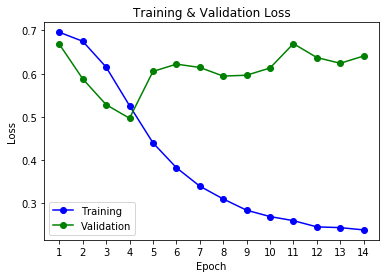

--------------------------------------------------------Now is 1 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)

We totally have 1034 training data after oversampling.

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:06.
current lr is: 1e-05

  Average training loss: 0.69
  Training epcoh took: 0:00:08

Running Validation...
  Macro F1 score: 0.49
  Validation Loss: 0.67
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:08.
current lr is: 7.500000000000001e-06

  Average training loss: 0.65
  Training epcoh took: 0:00:10

Running Validation...
  Macro F1 score: 0.64
  Validation Loss: 0.59
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:07.
current lr is: 5.625000000000001e-06

  Average training loss: 0.54
  Training epcoh took: 0:00:09

Running Validation...
  Macro F1 score: 0.62
  Validation Loss: 0.56
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:07.
current lr is: 4.21875000000

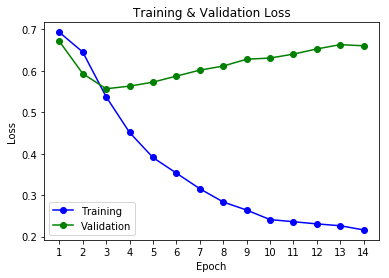

--------------------------------------------------------Now is 2 fold--------------------------------------------------------
[X training set shape, X test set shape]: (702,) (176,)

We totally have 1044 training data after oversampling.

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
  Batch    40  of     53.    Elapsed: 0:00:07.
current lr is: 1e-05

  Average training loss: 0.69
  Training epcoh took: 0:00:09

Running Validation...
  Macro F1 score: 0.56
  Validation Loss: 0.64
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
  Batch    40  of     53.    Elapsed: 0:00:07.
current lr is: 7.500000000000001e-06

  Average training loss: 0.60
  Training epcoh took: 0:00:09

Running Validation...
  Macro F1 score: 0.68
  Validation Loss: 0.56
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
  Batch    40  of     53.    Elapsed: 0:00:07.
current lr is: 5.625000000000001e-06

  Average training loss: 0.47
  Training epcoh took: 0:00:09

Running Validation...
  Macro F1 score: 0.69
  Validation Loss: 0.56
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
  Batch    40  of     53.    Elapsed: 0:00:07.
current lr is: 4.21875000000

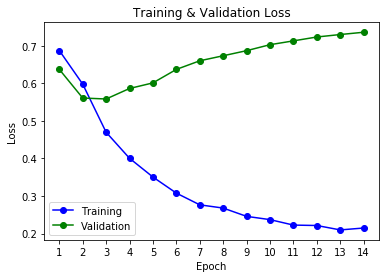

--------------------------------------------------------Now is 3 fold--------------------------------------------------------
[X training set shape, X test set shape]: (703,) (175,)

We totally have 1006 training data after oversampling.

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:07.
current lr is: 1e-05

  Average training loss: 0.70
  Training epcoh took: 0:00:09

Running Validation...
  Macro F1 score: 0.46
  Validation Loss: 0.65
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:07.
current lr is: 7.500000000000001e-06

  Average training loss: 0.67
  Training epcoh took: 0:00:09

Running Validation...
  Macro F1 score: 0.63
  Validation Loss: 0.63
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:07.
current lr is: 5.625000000000001e-06

  Average training loss: 0.64
  Training epcoh took: 0:00:09

Running Validation...
  Macro F1 score: 0.59
  Validation Loss: 0.62
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
  Batch    40  of     51.    Elapsed: 0:00:07.
current lr is: 4.21875000000

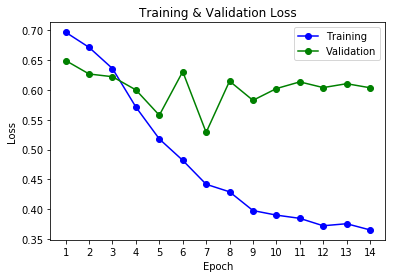

--------------------------------------------------------Now is 4 fold--------------------------------------------------------
[X training set shape, X test set shape]: (703,) (175,)

We totally have 1032 training data after oversampling.

======================Doing Bert classification task======================


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Rober


Training and evaluating the model.

======== Epoch 1 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:07.
current lr is: 1e-05

  Average training loss: 0.69
  Training epcoh took: 0:00:09

Running Validation...
  Macro F1 score: 0.61
  Validation Loss: 0.68
  Validation took: 0:00:01

======== Epoch 2 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:07.
current lr is: 7.500000000000001e-06

  Average training loss: 0.68
  Training epcoh took: 0:00:09

Running Validation...
  Macro F1 score: 0.56
  Validation Loss: 0.67
  Validation took: 0:00:01

======== Epoch 3 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:07.
current lr is: 5.625000000000001e-06

  Average training loss: 0.57
  Training epcoh took: 0:00:09

Running Validation...
  Macro F1 score: 0.69
  Validation Loss: 0.51
  Validation took: 0:00:01

======== Epoch 4 / 14 ========
Training...
  Batch    40  of     52.    Elapsed: 0:00:07.
current lr is: 4.21875000000

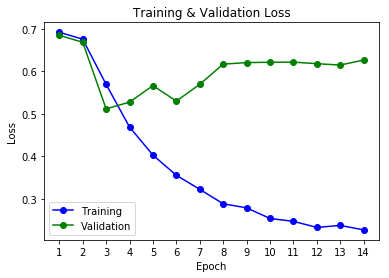

classification report on training set is:

              precision    recall  f1-score   support

     class 0       0.90      0.92      0.91      2564
     class 1       0.92      0.90      0.91      2564

    accuracy                           0.91      5128
   macro avg       0.91      0.91      0.91      5128
weighted avg       0.91      0.91      0.91      5128

classification report on test set is:

              precision    recall  f1-score   support

     class 0       0.52      0.53      0.52       237
     class 1       0.82      0.82      0.82       641

    accuracy                           0.74       878
   macro avg       0.67      0.67      0.67       878
weighted avg       0.74      0.74      0.74       878

confusion matrix on test set is:



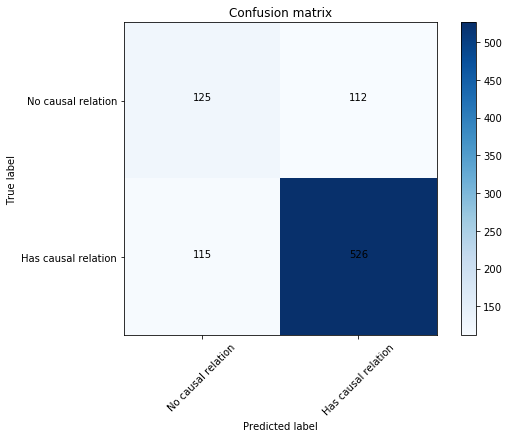

In [15]:
#Run single experiment
#transformer_run(X,y,best_args)

#Run kfold experiment
kfold_transformer_run(X,y,best_args)

## RESULT

Model| training set macro precision | training set macro recall | training set macro F1| evaluation set macro precision | evaluation set macro recall | evaluation set macro F1|
----------| --------- | ------ | ---- | ---------|----------| --------- | 
Bert           | 0.91        | 0.91     | <b>0.91</b> | 0.67 | 0.67 | <b>0.67</b> |
Transfer learning (BERT + LR)   | 0.90         | 0.90    | <b>0.90</b> | 0.61 | 0.61 | <b>0.61</b> |